!!

this model use cross-sectional normalization method

In [1]:
import lightgbm as lgbm
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing, feature_selection, metrics, model_selection, decomposition

import random
from itertools import product
import pickle

import psutil
import warnings
warnings.filterwarnings('ignore')

idx = pd.IndexSlice


In [2]:
input_directory = Path(r"..\\..\\Data\\Input")

feature_directory = Path(r"..\\..\\Data\\Feature")

model_name = "model_lgbm_03"
model_directory = Path()/model_name
model_directory.mkdir(exist_ok=True)


### Import Data

In [3]:
df_data = pd.read_parquet(input_directory/'train_low_mem.parquet', engine='pyarrow').set_index(['time_id','investment_id'])
df_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3141410 entries, (0, 1) to (1219, 3773)
Columns: 302 entries, row_id to f_299
dtypes: float32(301), object(1)
memory usage: 3.6+ GB


In [4]:
df_data = df_data.drop('row_id', axis=1)
df_data.head()

target       f_0       f_1       f_2       f_3  \
time_id investment_id                                                     
0       1             -0.300875  0.932573  0.113691 -0.402206  0.378386   
        2             -0.231040  0.810802 -0.514115  0.742368 -0.616673   
        6              0.568807  0.393974  0.615937  0.567806 -0.607963   
        7             -1.064780 -2.343535 -0.011870  1.874606 -0.606346   
        8             -0.531940  0.842057 -0.262993  2.330030 -0.583422   

                            f_4       f_5       f_6       f_7       f_8  ...  \
time_id investment_id                                                    ...   
0       1             -0.203938 -0.413469  0.965623  1.230508  0.114809  ...   
        2             -0.194255  1.771210  1.428127  1.134144  0.114809  ...   
        6              0.068883 -1.083155  0.979656 -1.125681  0.114809  ...   
        7             -0.586827 -0.815737  0.778096  0.298990  0.114809  ...   
        8             -0.618392 -0.742814 -0.946789  1.230508  0.114809  ...   

                          f_290     f_291     f_292     f_293     f_294  \
time_id investment_id                                                     
0       1              0.366028 -1.095620  0.200075  0.819155  0.941183   
        2             -0.154193  0.912726 -0.734579  0.819155  0.941183   
        6             -0.138020  0.912726 -0.551904 -1.220772 -1.060166   
        7              0.382201  0.912726 -0.266359 -1.220772  0.941183   
        8             -0.170365  0.912726 -0.741355 -1.220772  0.941183   

                          f_295     f_296     f_297     f_298     f_299  
time_id investment_id                                                    
0       1             -0.086764 -1.087009 -1.044826 -0.287605  0.321566  
        2             -0.387617 -1.087009 -0.929529 -0.974060 -0.343624  
        6             -0.219097 -1.087009 -0.612428 -0.113944  0.243608  
        7             -0.609113  0.104928 -0.783423  1.151730 -0.773309  
        8             -0.588445  0.104928  0.753279  1.345611 -0.737624  

[5 rows x 301 columns]

### Feature Engineering

##### Normalization

In [5]:
df_data_norm = df_data.copy()

for i in tqdm(range(293, 294)):
    feature = f'f_{i}'

    df_data_norm[feature] = df_data[feature].groupby(level='time_id').apply(
        lambda x: pd.DataFrame(preprocessing.RobustScaler(quantile_range=(1., 99.), with_scaling=True, with_centering=True).fit_transform(x.values.reshape(-1, 1)), index=x.index, columns=[f'f_{i}']))

    # df_data_norm[feature] = df_data[feature].groupby(
    #     level='time_id').apply(lambda x: pd.DataFrame())

    # df_data_norm[feature] = df_data[feature].groupby(level='time_id').apply(
    #     lambda x: 2*x.rank(pct=True)-1).astype(np.float32)


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


In [3]:
# df_data_norm.to_parquet(input_directory/'train_norm2.parquet')
df_data_norm = pd.read_parquet(input_directory/'train_norm2.parquet', engine='pyarrow')

<AxesSubplot:title={'center':'histgram of normalized feature'}, ylabel='Frequency'>

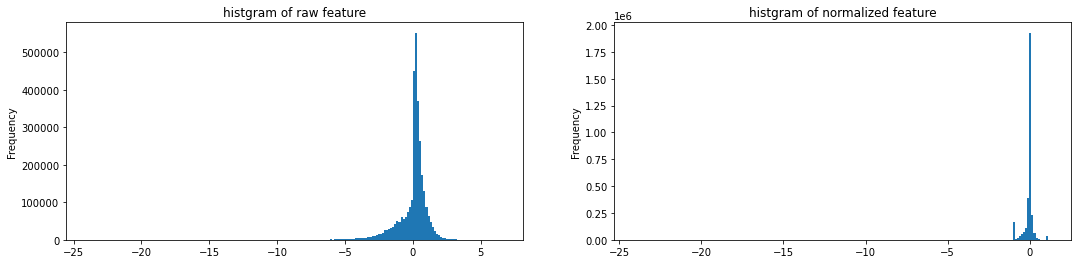

In [7]:
fig = plt.figure(figsize=(18, 4))
ax = plt.subplot(121)
df_data['f_293'].plot(kind='hist', bins=200, ax=ax, title="histgram of raw feature")

ax = plt.subplot(122)
df_data_norm['f_293'].plot(kind='hist', bins=200, ax=ax, title="histgram of normalized feature")

### Feature_selection

In [5]:
df_feature_selection = pd.DataFrame()

for i in tqdm(range(300)):
    feature = f'f_{i}'
    df_feature_selection.loc[feature, 'corr'] = np.corrcoef(
        df_data_norm['target'], df_data_norm[feature])[0][1]


100%|██████████| 300/300 [00:09<00:00, 30.16it/s]


In [6]:
n = len(df_data_norm)
rand_k_index = random.sample(range(n), n//50)
rand_k_index.sort()

mi = feature_selection.mutual_info_regression(
    df_data_norm.iloc[rand_k_index, :].filter(like='f_'), df_data_norm.iloc[rand_k_index, :]['target'])
df_feature_selection['mutual_information'] = mi



In [11]:
all_feature = set([f'f_{i}' for i in range(300)])

selected_feature_bycorr = df_feature_selection[np.abs(
    df_feature_selection['corr']) > 0.03].index

selected_feature_bymi = df_feature_selection[(
    df_feature_selection['mutual_information']) > 0.03].index

direct_feature = set(selected_feature_bycorr).union(set(selected_feature_bymi))
pca_feature = all_feature - direct_feature

print(
    f'seleced feature by corr: {len(selected_feature_bycorr)}, seleced feature by mutual information: {len(selected_feature_bymi)}, pca_feature: {len(pca_feature)}')


seleced feature by corr: 69, seleced feature by mutual information: 31, pca_feature: 215


In [12]:
n_components = 5

pca_transform = decomposition.PCA(n_components=n_components).fit(
    df_data_norm[list(pca_feature)])

add_feature = [f'f_{i}' for i in range(300, 300+n_components)]
df_data_norm[add_feature] = pca_transform.transform(
    df_data_norm[list(pca_feature)])

selected_feature = list(selected_feature_bycorr.union(
    selected_feature_bymi).union(set(add_feature)))


In [13]:
pca_transform.explained_variance_ratio_

array([9.68069215e-01, 3.02137340e-02, 1.35462302e-03, 2.38742422e-04,
       1.13931950e-04])

In [14]:
feature_dict = {}
feature_dict['direct_feature'] = direct_feature
feature_dict['pca_feature'] = pca_feature
feature_dict['selected_feature'] = selected_feature

In [15]:
f = open(model_directory/'pickle_feature_dict', 'wb')
pickle.dump(feature_dict, f)
f.close()

In [16]:
f = open(model_directory/'pickle_pca_transform', 'wb')
pickle.dump(pca_transform, f)
f.close()

### Split Feature & target

In [17]:
feature = df_data_norm[selected_feature]
target = df_data_norm['target']
target

time_id  investment_id
0        1               -0.300875
         2               -0.231040
         6                0.568807
         7               -1.064780
         8               -0.531940
                            ...   
1219     3768             0.033600
         3769            -0.223264
         3770            -0.559415
         3772             0.009599
         3773             1.212112
Name: target, Length: 3141410, dtype: float32

In [18]:
feature

f_100     f_106     f_113     f_116     f_118  \
time_id investment_id                                                     
0       1              0.192027  0.017016  0.073610  0.210865 -0.100765   
        2             -0.255442 -0.164260  0.342538  0.011094 -0.060851   
        6              0.297089  0.026361 -0.041825  0.003122  0.282316   
        7             -0.255442 -0.205876 -0.073849 -0.183203  0.008758   
        8             -0.255442 -0.301800 -0.153357 -0.222183  0.019647   
...                         ...       ...       ...       ...       ...   
1219    3768           0.000000 -0.141616 -0.035290 -0.038146  0.016723   
        3769           0.000000  0.162639 -0.038975 -0.150717  0.061353   
        3770           0.000000  0.177528 -0.008774  0.050733 -0.019542   
        3772           0.000000 -0.220696  0.135521 -0.019791 -0.011196   
        3773           0.343079  0.090942  0.387812  0.613638  0.074531   

                          f_119     f_131     f_134     f_135     f_136  ...  \
time_id investment_id                                                    ...   
0       1              0.026929  0.138814  0.208146 -0.173833  0.079784  ...   
        2              0.018185  0.145477  0.083320 -0.257606  0.171688  ...   
        6              0.027471 -0.038746 -0.017470 -0.208312  0.027404  ...   
        7              0.042183  0.005855 -0.430101 -0.393357 -0.070752  ...   
        8              0.008979 -0.154307 -0.489211 -0.114888 -0.094564  ...   
...                         ...       ...       ...       ...       ...  ...   
1219    3768           0.046739 -0.039272 -0.153660 -0.006646 -0.053263  ...   
        3769           0.047369 -0.065059 -0.390497  0.253022 -0.098815  ...   
        3770          -0.381079  0.060462  0.010291  0.175916  0.237945  ...   
        3772           0.092388  0.538250  0.029525 -0.439641  0.072688  ...   
        3773           0.062754  0.487937  0.527026 -0.077480  0.232622  ...   

                           f_71      f_76      f_79      f_80      f_83  \
time_id investment_id                                                     
0       1              0.062921  0.119544  0.316252  0.038074  0.160425   
        2              0.084177 -0.092911  0.375475  0.005222 -0.064018   
        6             -0.065740  0.044978 -0.042679  0.002027  0.006497   
        7             -0.032398  0.300716 -0.068918 -0.053083  0.102318   
        8             -0.103207  0.190838 -0.110415 -0.139631  0.187966   
...                         ...       ...       ...       ...       ...   
1219    3768          -0.056961 -0.040048  0.000877 -0.064088  0.031894   
        3769          -0.035554  0.056784 -0.051380 -0.095180  0.242559   
        3770           0.298558  0.186153 -0.047562  0.434521 -0.125435   
        3772           0.020812  0.083768  0.009110 -0.067279 -0.045421   
        3773           0.132185 -0.172461  0.197766 -0.037187  0.020845   

                           f_85      f_90      f_92      f_93      f_96  
time_id investment_id                                                    
0       1              0.048742 -0.357232 -0.095132 -0.091216  0.002334  
        2             -0.421072  0.027877  0.103813  0.149060 -0.327247  
        6              0.039724  0.062236 -0.166646 -0.262775  0.036795  
        7             -0.378986 -0.295236 -0.068799  0.086340 -0.510432  
        8             -0.454139 -0.310634  0.045414  0.111297  0.055299  
...                         ...       ...       ...       ...       ...  
1219    3768          -0.281003  0.000000  0.150751  0.016825 -0.058204  
        3769          -0.298068 -0.091751  0.049813  0.023106 -0.065347  
        3770          -0.353314  0.000000 -0.070960  0.010069 -0.173889  
        3772          -0.486368  0.000000  0.072513  0.028068  0.014432  
        3773           0.228071  0.192840  0.189388 -0.134356  0.200586  

[3141410 rows x 90 columns]

###  Split Train & Test

In [19]:
train_test_ratio = 5

uniquedate = target.index.get_level_values(level='time_id').unique().tolist()
train_start = 0
train_end = uniquedate[int(
    len(uniquedate)*train_test_ratio/(train_test_ratio+1))]
test_start = uniquedate[int(
    len(uniquedate)*train_test_ratio/(train_test_ratio+1))+1]
test_end = 1219


# dates of train, dates of test
print(
    f'train_start: {train_start}, train_end: {train_end}, test_start: {test_start}, test_end: {test_end}')

feature_train = feature.loc[idx[train_start:train_end, :], :]
feature_test = feature.loc[idx[test_start:test_end, :], :]

target_train = target.loc[idx[train_start:train_end, :]]
target_test = target.loc[idx[test_start:test_end, :]]


train_start: 0, train_end: 1018, test_start: 1019, test_end: 1219


### Train Model

In [20]:
def feval_mse_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'mse', round(metrics.mean_squared_error(y_true=labels, y_pred=preds), 5), False


def feval_mape_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'mape', round(metrics.mean_absolute_percentage_error(y_true=labels, y_pred=preds), 5), False


def feval_r2_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'r2_score', round(metrics.r2_score(y_true=labels, y_pred=preds), 5), True


def corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0][1]


def feval_corr_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'corr_score', round(corr(y_true=labels, y_pred=preds), 5), True


class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = min(
                train_end_idx + self.train_length + self.lookahead - 1, len(days) - 1)
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:
            # print(train_start, train_end)
            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


def get_train_valid_data(X, y, train_idx, valid_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[valid_idx, :], y.iloc[valid_idx]
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # x_train = scaler.fit_transform(x_train)
    # x_val = scaler.transform(x_val)
    return (x_train, y_train,
            x_val, y_val)


In [21]:
param_names = ['objective', 'num_iterations', 'learning_rate', 'early_stopping_rounds', 'verbose',
               'max_depth', 'num_leaves', 'lambda_l1', 'lambda_l2',
               'feature_fraction',
               'bagging_fraction',
               'extra_trees']

# For Better Accuracy
objective = ['huber']
num_iterations = [2000]
learning_rate = [0.25]
early_stopping_rounds = [25]
verbose = [-1]
# Deal with Over-fitting
max_depth = [-1]
num_leaves = [45]
lambda_l1 = [0]
lambda_l2 = [0]
feature_fraction = [1]
bagging_fraction = [1]
extra_trees = [True]

cv_params = list(product(objective,
                         num_iterations,
                         learning_rate,
                         early_stopping_rounds,
                         verbose,
                         max_depth,
                         num_leaves,
                         lambda_l1,
                         lambda_l2,
                         feature_fraction,
                         bagging_fraction,
                         extra_trees
                         ))

n_splits = 5
train_valid_ratio = 0.2


In [22]:
best_metrics = np.inf
best_models_list = []
best_params = {}

for params_tuple in cv_params:

    params = {param_names[i]: x for (i, x) in enumerate(params_tuple)}
    print('#############################################################################################################################################')
    print('Parmas: ', params, '\n')

    # models_list, metrics_dict = model_train(
    #     model_type, feature_train, target_train, n_splits, train_test_ratio, params)
    date_length = len(feature_train.index.get_level_values(
        level='time_id').unique().tolist())

    train_length = int(date_length/(1+n_splits*train_test_ratio))
    valid_length = int(train_length * train_test_ratio)

    # print(
    #     f'train_date_length: {train_length}, test_date_length: {test_length}')
    # cv = MultipleTimeSeriesCV(n_splits=n_splits,
    #                           lookahead=1,
    #                           test_period_length=valid_length,
    #                           train_period_length=train_length,
    #                           date_idx='time_id'
    #                           )
    cv = model_selection.KFold(
        n_splits=n_splits, random_state=2021, shuffle=True)

    models_list = []
    metrics_dict = pd.DataFrame()

    for i, (train_idx, valid_idx) in enumerate(cv.split(X=feature_train)):
        X_train, y_train, X_valid, y_valid = get_train_valid_data(
            feature_train, target_train, train_idx, valid_idx)

        lgbm_train = lgbm.Dataset(
            X_train, y_train
        )
        lgbm_valid = lgbm.Dataset(
            X_valid, y_valid, reference=lgbm_train
        )

        model = lgbm.train(params=params,
                           train_set=lgbm_train,
                           valid_sets=[lgbm_train, lgbm_valid],
                           #    num_boost_round=1000,
                           feval=[feval_mse_score, feval_corr_score],
                           verbose_eval=100,
                           )

        # y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

        y_train_fit = model.predict(
            X_train, num_iteration=model.best_iteration)
        y_valid_fit = model.predict(
            X_valid, num_iteration=model.best_iteration)

        r2_train = metrics.r2_score(y_train, y_train_fit)
        r2_valid = metrics.r2_score(y_valid, y_valid_fit)
        corr_train = corr(y_train, y_train_fit)
        corr_valid = corr(y_valid, y_valid_fit)
        mse_train = metrics.mean_squared_error(
            y_train, y_train_fit)
        mse_valid = metrics.mean_squared_error(y_valid, y_valid_fit)
        print('---------------------------------------------------------------------------------------------------------------------------------------------')
        print(f'cv: {i+1:01} | mse_train: {mse_train:.5f} | corr_train: {corr_train:0.5f} | mse_valid: {mse_valid:.5f} | corr_valid: {corr_valid:0.5f}')
        print('---------------------------------------------------------------------------------------------------------------------------------------------')
        models_list.append(model)
        metrics_dict.loc[i, 'corr_train'] = corr_train
        metrics_dict.loc[i, 'corr_valid'] = corr_valid
        metrics_dict.loc[i, 'mse_train'] = mse_train
        metrics_dict.loc[i, 'mse_valid'] = mse_valid

    metrics_dict = metrics_dict.mean(axis=0)
    corr_train, corr_valid, mse_train, mse_valid = tuple(
        metrics_dict)
    print(
        f' mean | mse_train: {mse_train:.5f} | corr_train: {corr_train:0.5f} | mse_valid: {mse_valid:.5f} | corr_valid: {corr_valid:0.5f}')
    print()

    if metrics_dict['mse_train'] < best_metrics:
        best_metrics = metrics_dict['mse_train']
        best_models_list = models_list.copy()
        best_params = params


#############################################################################################################################################
Parmas:  {'objective': 'huber', 'num_iterations': 2000, 'learning_rate': 0.25, 'early_stopping_rounds': 25, 'verbose': -1, 'max_depth': -1, 'num_leaves': 31, 'lambda_l1': 0, 'lambda_l2': 0, 'feature_fraction': 0.8, 'bagging_fraction': 1, 'extra_trees': True} 

Training until validation scores don't improve for 25 rounds
[100]	training's huber: 0.293941	training's mse: 0.83695	training's corr_score: 0.15058	valid_1's huber: 0.296492	valid_1's mse: 0.8463	valid_1's corr_score: 0.13785
[200]	training's huber: 0.292218	training's mse: 0.83161	training's corr_score: 0.17115	valid_1's huber: 0.295681	valid_1's mse: 0.84376	valid_1's corr_score: 0.14805
[300]	training's huber: 0.290865	training's mse: 0.82732	training's corr_score: 0.18673	valid_1's huber: 0.295282	valid_1's mse: 0.84247	valid_1's corr_score: 0.15294
[400]	training's huber: 0.289641	tra

In [23]:
y_test_fit_list = []
for (i, model) in enumerate(best_models_list):
    y_test_fit = model.predict(feature_test)
    y_test_fit_list.append(y_test_fit)

y_test_fit = pd.DataFrame(index=feature_test.index)
y_test_fit['actual'] = target_test
y_test_fit['predict'] = np.mean(y_test_fit_list, axis=0).squeeze()

corr_train = corr(y_test_fit['actual'], y_test_fit['predict'])
corr_test = corr(y_test_fit['actual'], y_test_fit['predict'])
mse_train = metrics.mean_squared_error(y_test_fit['actual'], y_test_fit['predict'])
mse_test = metrics.mean_squared_error(y_test_fit['actual'], y_test_fit['predict'])
print(
    f' test | mse_test: {mse_train:.5f} | corr_test: {corr_train:0.5}')

 test | mse_test: 0.80775 | corr_test: 13.13044%


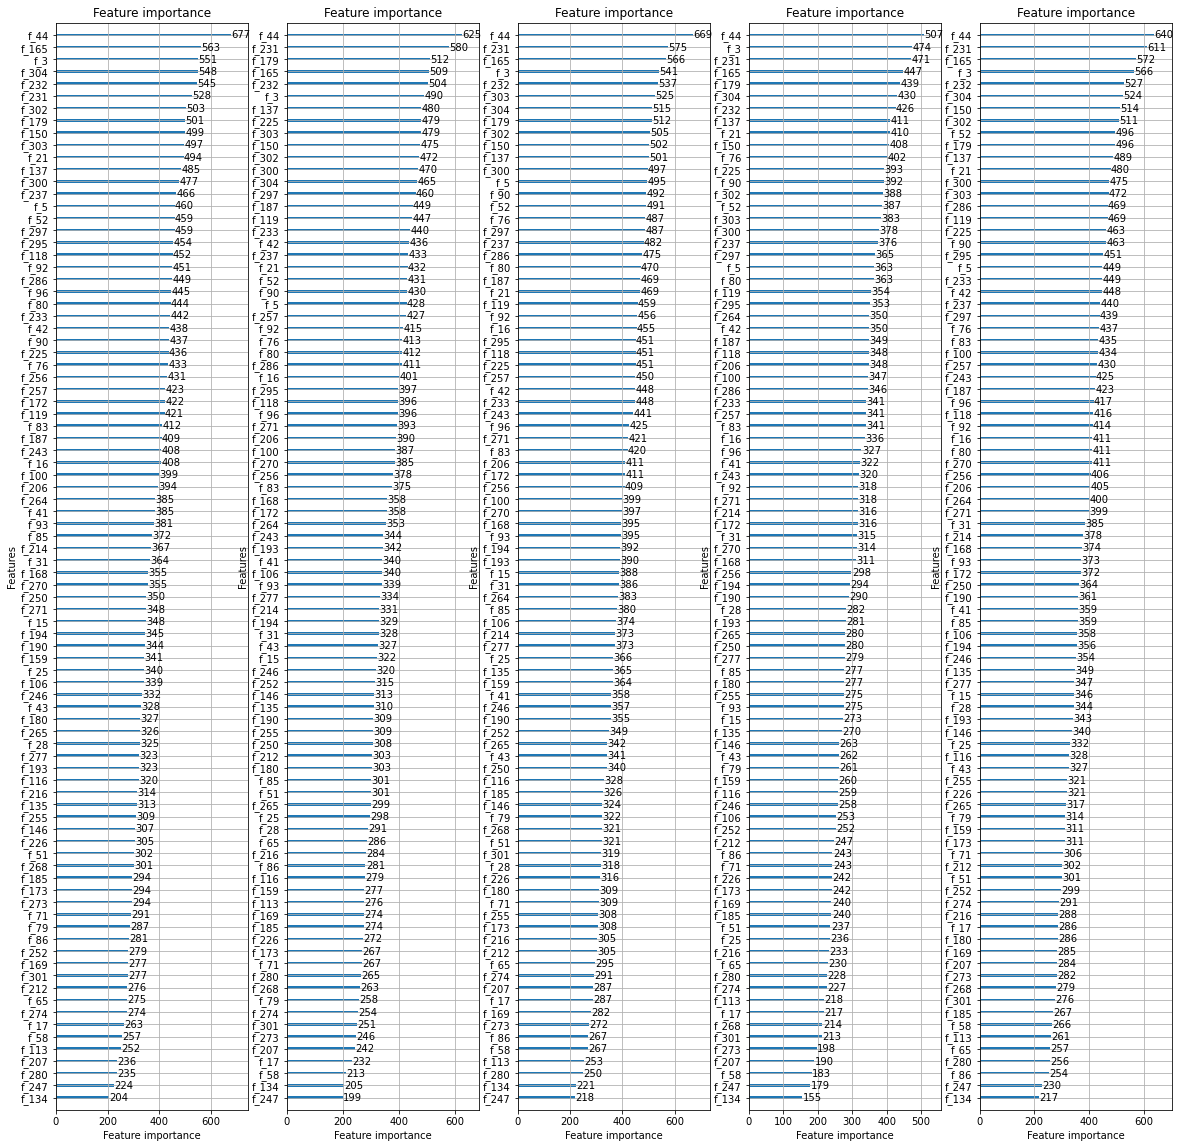

In [24]:
fig = plt.figure(figsize=(20, 20))
for (i, model) in enumerate(best_models_list):
    ax = plt.subplot(1, 5, i+1)
    lgbm.plot_importance(model, max_num_features=100, ax=ax)


In [ ]:
f = open(model_directory/'pickle_best_models_list', 'wb')
pickle.dump(best_models_list, f)
f.close()

In [ ]:
f1 = open(model_directory/'pickle_best_models_list', 'rb')
models_list = pickle.load(f1)